# Pre-training on Casia webface

## Load the data

In [1]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt

batch_size = 1024
image_size = 112
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'Casia webface', 'archive', 'casia-webface'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    color_mode = 'rgb'
)



2024-11-03 08:33:25.266408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 08:33:25.375160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 08:33:25.408884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 08:33:25.614538: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 08:33:26.781353: W tensorflow/compiler/tf2

Found 490623 files belonging to 10572 classes.


I0000 00:00:1730612027.852462    4423 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730612028.101800    4423 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730612028.102139    4423 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730612028.103552    4423 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [2]:
num_classes = 10572

## Configure the hyperparamters

In [ ]:
learning_rate = 0.0001
weight_decay = 0.00001
num_epochs = 500
patch_size = 28
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [
    2048, 
    1024
]


## Date augmentation for better generalization

In [4]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(factor = 0.02),
        keras.layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = 'data_augmentation'
)

## Patch creation layer

In [5]:
@keras.saving.register_keras_serializable("Patches")
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    
    def call(self, images):
        input_shape = keras.ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size = self.patch_size)
        patches = keras.ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels
            )
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({'patch_size' : self.patch_size})
        return {**config, 'patch_size' : self.patch_size}

## Demonstrate the patches in action

In [6]:
image = 0
for batch in dataset:
    image = batch[0][10]
    break

image = keras.ops.convert_to_tensor([image])

In [7]:
patches = Patches(patch_size)(image)

2024-11-03 08:33:49.977444: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730612030.206524    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.234025    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.242127    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.242972    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.245380    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.248236    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.251891    4423 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612030.283977    4423 gpu_t

Image size: 112 X 112
Patch size: 28 X 28
Patches per image: 16
Elements per patch: 2352


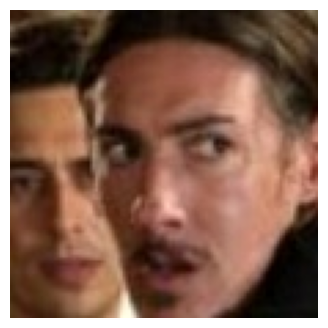

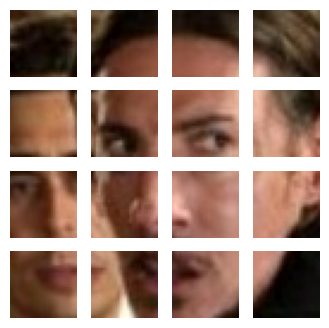

In [8]:
plt.figure(figsize = (4, 4))
plt.imshow(image[0].numpy().astype(np.uint8))
plt.axis('off')


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

## Patch encoding layer

In [9]:
@keras.saving.register_keras_serializable("PatchEncoder")
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = keras.layers.Dense(units = self.projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )
    
    def call(self, patches):
        positions = keras.ops.expand_dims(
            keras.ops.arange(start = 0, stop = self.num_patches, step = 1), axis = 0
        )
        projected_patches = self.projection(patches)
        encoded = projected_patches + self.position_embedding(positions)
        
        return encoded

    def get_config(self):
        config = super().get_config()
        return {**config, 'num_patches' : self.num_patches, 'projection_dim' : self.projection_dim}


## Build the Vision Transformer

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=keras.activations.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

In [11]:
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = keras.layers.Dense(num_classes, activation = keras.activations.softmax)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Training

In [12]:
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 1', 'ViT 1.keras')
# model = create_vit_classifier()
# model.compile(
#     optimizer = optimizer,
#     loss = keras.losses.SparseCategoricalCrossentropy(),
#     metrics = [
#         keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
#         keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
#     ]
# )
model = keras.models.load_model(checkpoint_path, custom_objects = {
    "PatchEncoder" : PatchEncoder(num_patches, projection_dim),
    "Patches" : Patches(patch_size)
})

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True
)

history = model.fit(
    dataset,
    batch_size = batch_size,
    epochs = num_epochs,
    callbacks = [checkpoint_callback]
)

/home/thoalfeqar/miniconda3/envs/tf/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'patch_encoder_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/500


W0000 00:00:1730612040.550371    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.592584    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.711124    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.835224    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.861482    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.888332    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.925210    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612040.959500    4631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612041.030955    4631 gp

479/480 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4521 - loss: 2.8612 - top_5_accuracy: 0.6511

W0000 00:00:1730612146.457575    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.461779    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.471627    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.482403    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.485549    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.488575    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.492745    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.497373    4635 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730612146.505485    4635 gp

480/480 ━━━━━━━━━━━━━━━━━━━━ 116s 218ms/step - accuracy: 0.4521 - loss: 2.8613 - top_5_accuracy: 0.6511
Epoch 2/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step - accuracy: 0.4433 - loss: 2.9263 - top_5_accuracy: 0.6433
Epoch 3/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step - accuracy: 0.4520 - loss: 2.8675 - top_5_accuracy: 0.6518
Epoch 4/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step - accuracy: 0.4398 - loss: 2.9532 - top_5_accuracy: 0.6401
Epoch 5/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 200ms/step - accuracy: 0.4478 - loss: 2.8896 - top_5_accuracy: 0.6488
Epoch 6/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step - accuracy: 0.4428 - loss: 2.9265 - top_5_accuracy: 0.6432
Epoch 7/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step - accuracy: 0.4355 - loss: 2.9740 - top_5_accuracy: 0.6356
Epoch 8/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 96s 199ms/step - accuracy: 0.4111 - loss: 3.1819 - top_5_accuracy: 0.6076
Epoch 9/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 97s 202ms/step - accuracy: 0.4522 - loss: 2.8590 -

KeyboardInterrupt: 